In [ ]:
# Cell 0: (Optional) Install required packages (run once)
# If using Colab, run this cell. If running locally, ensure packages are installed.
!pip install -q pandas numpy scikit-learn matplotlib seaborn shap lime joblib scikit-image pdpbox

# Note: pdpbox is optional for PDP plotting; shap and lime are heavy but useful.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 9.2 MB/s eta 0:00:00


In [ ]:
# Cell 1: Imports & constants
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import joblib
import shap
from lime.lime_tabular import LimeTabularExplainer

plt.style.use('seaborn-v0_8')

%matplotlib inline


# File path and settings
DATA_PATH = "/content/weight_change_dataset.csv"  # change if needed
TARGET = None   # if None we'll auto-detect (falls back to last column)
RANDOM_STATE = 42


In [ ]:
# Cell 2: Load dataset & quick EDA
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nTarget candidates (common names):",
      [c for c in df.columns if c.lower() in ('target','label','y','class','final weight','final weight (lbs)','final_weight')])
df.describe()
# Select only numerical columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Summary statistics (mean, std, min, max)
summary_stats = numeric_df.describe().T

# Add median column separately (numeric-only)
summary_stats['median'] = numeric_df.median()

summary_stats


Shape: (100, 13)


,Participant ID,Age,Gender,Current Weight (lbs),BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Physical Activity Level,Sleep Quality,Stress Level,Final Weight (lbs)
0,1,56,M,228.4,3102.3,3916.0,813.7,0.2,1,Sedentary,Excellent,6,228.6
1,2,46,F,165.4,2275.5,3823.0,1547.5,2.4,6,Very Active,Excellent,6,167.8
2,3,32,F,142.8,2119.4,2785.4,666.0,1.4,7,Sedentary,Good,3,144.2
3,4,25,F,145.5,2181.3,2587.3,406.0,0.8,8,Sedentary,Fair,2,146.3
4,5,38,M,155.5,2463.8,3312.8,849.0,2.0,10,Lightly Active,Good,1,157.5



Columns: ['Participant ID', 'Age', 'Gender', 'Current Weight (lbs)', 'BMR (Calories)', 'Daily Calories Consumed', 'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)', 'Duration (weeks)', 'Physical Activity Level', 'Sleep Quality', 'Stress Level', 'Final Weight (lbs)']

Dtypes:
 Participant ID                     int64
Age                                int64
Gender                            object
Current Weight (lbs)             float64
BMR (Calories)                   float64
Daily Calories Consumed          float64
Daily Caloric Surplus/Deficit    float64
Weight Change (lbs)              float64
Duration (weeks)                   int64
Physical Activity Level           object
Sleep Quality                     object
Stress Level                       int64
Final Weight (lbs)               float64
dtype: object

Missing values:
 Participant ID                   0
Age                              0
Gender                           0
Current Weight (lbs)             0
BMR (Calorie

,count,mean,std,min,25%,50%,75%,max,median
Participant ID,100.0,50.500000,29.011492,1.000000,25.750000,50.50,75.250,100.0,50.50
Age,100.0,37.910000,12.219454,18.000000,26.750000,38.00,46.250,59.0,38.00
Current Weight (lbs),100.0,171.533000,30.333856,100.000000,153.650000,172.15,192.475,238.2,172.15
BMR (Calories),100.0,2518.206000,364.431221,1566.500000,2255.050000,2519.50,2805.975,3390.8,2519.50
Daily Calories Consumed,100.0,3518.292000,513.313097,2030.900000,3233.300000,3636.05,4000.000,4000.0,3636.05
Daily Caloric Surplus/Deficit,100.0,1000.091000,371.560827,82.500000,766.950000,1013.10,1253.325,1922.5,1013.10
Weight Change (lbs),100.0,-2.779817,7.443719,-35.678115,-5.012312,0.10,1.850,5.0,0.10
Duration (weeks),100.0,6.920000,3.515277,1.000000,4.000000,7.00,10.000,12.0,7.00
Stress Level,100.0,4.810000,2.576879,1.000000,2.750000,5.00,7.000,9.0,5.00
Final Weight (lbs),100.0,168.750000,30.588004,98.200000,149.550000,169.80,188.300,232.5,169.80


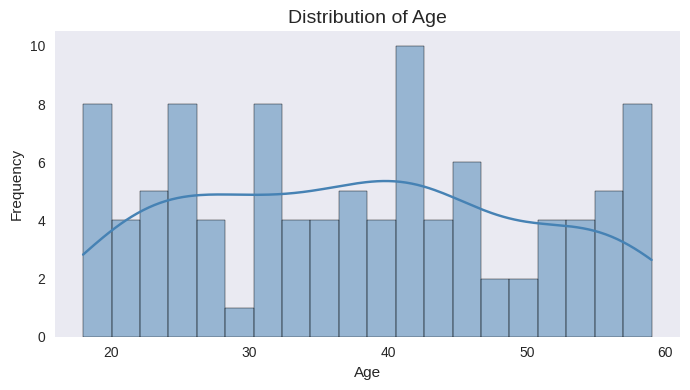

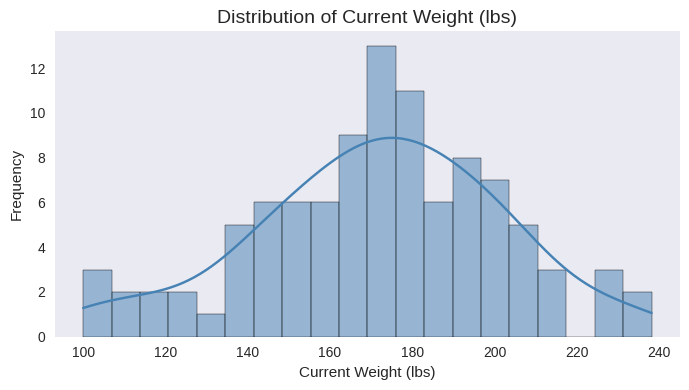

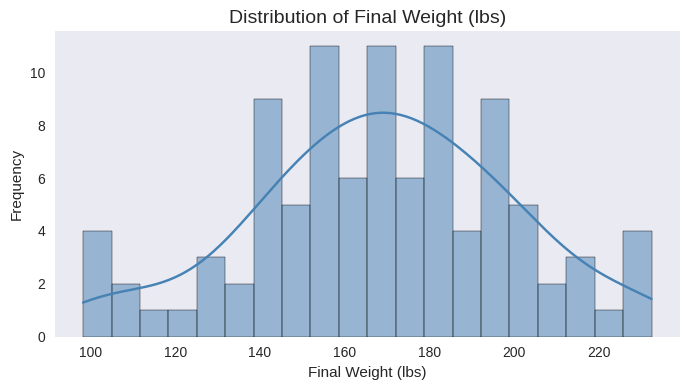

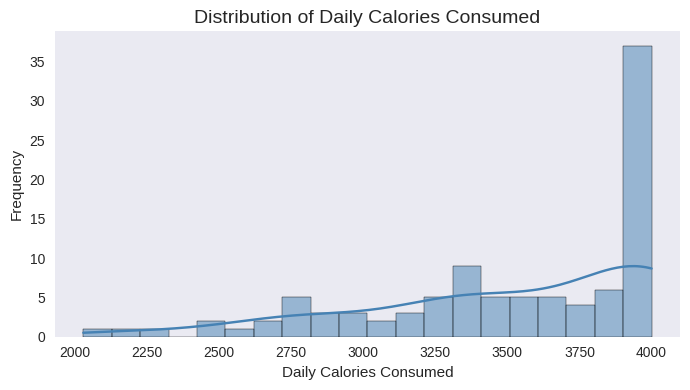

⚠ Feature missing: Carbohydrate Intake (g)
⚠ Feature missing: Protein Intake (g)
⚠ Feature missing: Fat Intake (g)


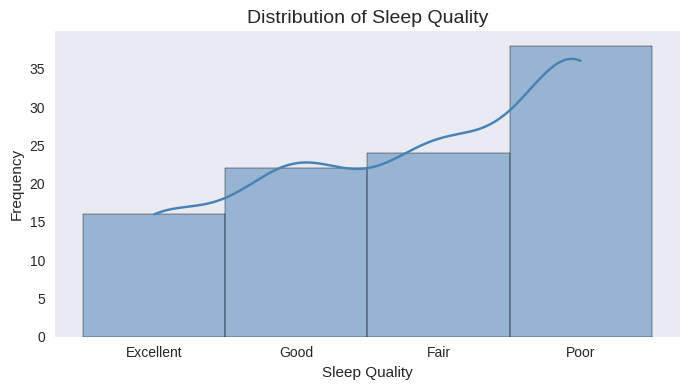

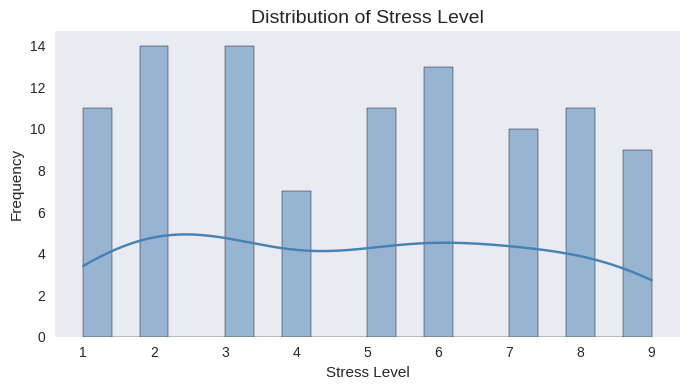

In [ ]:
# ================================
# Distribution Plots (Histograms + KDE)
# ================================

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

# Select key numerical features
features = [
    "Age",
    "Current Weight (lbs)",
    "Final Weight (lbs)",
    "Daily Calories Consumed",
    "Carbohydrate Intake (g)",
    "Protein Intake (g)",
    "Fat Intake (g)",
    "Sleep Quality",
    "Stress Level"
]

# Generate histogram + KDE for each feature
for feat in features:
    if feat in df.columns:
        plt.figure(figsize=(7, 4))
        sns.histplot(df[feat], kde=True, bins=20, color='steelblue')
        plt.title(f"Distribution of {feat}", fontsize=14)
        plt.xlabel(feat)
        plt.ylabel("Frequency")
        plt.grid(False)
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠ Feature missing: {feat}")


In [ ]:
import difflib

target = "Final_Weight"
cols = df.columns.tolist()

print("Closest match:", difflib.get_close_matches(target, cols, n=1))


Closest match: ['Final Weight (lbs)']


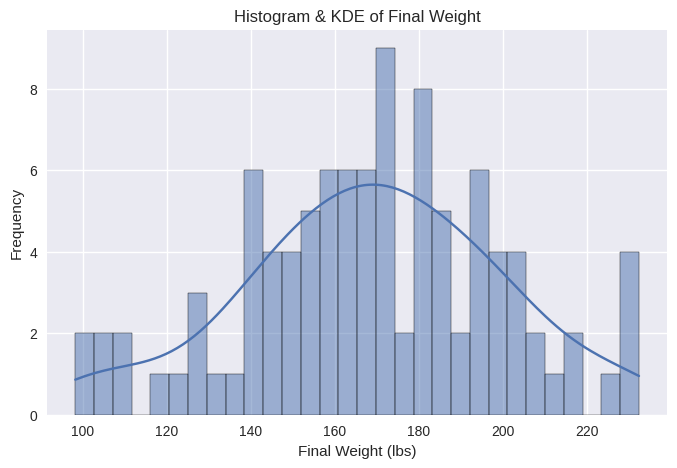

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df["Final Weight (lbs)"], kde=True, bins=30)

plt.title("Histogram & KDE of Final Weight")
plt.xlabel("Final Weight (lbs)")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Cell 3: Choose target & drop ID-like columns
# Heuristic: if TARGET set, use it; else use 'Final Weight (lbs)' if exists, else last column
if TARGET:
    target_col = TARGET
elif 'Final Weight (lbs)' in df.columns:
    target_col = 'Final Weight (lbs)'
else:
    target_col = df.columns[-1]

# Drop id-like columns
id_candidates = [c for c in df.columns if c.lower() == 'id' or ('id' in c.lower() and df[c].nunique() == len(df))]
print("ID-like columns to drop:", id_candidates)
df = df.drop(columns=id_candidates, errors='ignore')

print("Using target:", target_col)
display(df[[target_col]].head())


ID-like columns to drop: []
Using target: Final Weight (lbs)


,Final Weight (lbs)
0,228.6
1,167.8
2,144.2
3,146.3
4,157.5


In [ ]:
# Cell 3: Choose target & drop ID-like columns
# Heuristic: if TARGET set, use it; else use 'Final Weight (lbs)' if exists, else last column
if TARGET:
    target_col = TARGET
elif 'Final Weight (lbs)' in df.columns:
    target_col = 'Final Weight (lbs)'
else:
    target_col = df.columns[-1]

# Drop id-like columns
id_candidates = [c for c in df.columns if c.lower() == 'id' or ('id' in c.lower() and df[c].nunique() == len(df))]
print("ID-like columns to drop:", id_candidates)
df = df.drop(columns=id_candidates, errors='ignore')

print("Using target:", target_col)
display(df[[target_col]].head())


ID-like columns to drop: []
Using target: Final Weight (lbs)


,Final Weight (lbs)
0,228.6
1,167.8
2,144.2
3,146.3
4,157.5


In [ ]:
# Cell 4: Split X and y, inspect types
X = df.drop(columns=[target_col])
y = df[target_col]

print("X shape:", X.shape)
print("y dtype:", y.dtype)
print("y sample values (first 20):", y.values[:20])

# List numeric and categorical features
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


X shape: (100, 11)
y dtype: float64
y sample values (first 20): [228.6 167.8 144.2 146.3 157.5 140.4 104.9 172.2 161.  169.2 189.5 140.4
 148.5 180.6 165.8 180.7 168.8 158.5 213.3 204.1]
Numeric columns: ['Age', 'Current Weight (lbs)', 'BMR (Calories)', 'Daily Calories Consumed', 'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)', 'Duration (weeks)', 'Stress Level']
Categorical columns: ['Gender', 'Physical Activity Level', 'Sleep Quality']


In [ ]:
# Cell 5: Imputation & preprocessing pipeline setup
# Numeric: median impute -> StandardScaler
# Categorical: mode impute -> OneHotEncoder (drop='first')
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ], remainder='drop'  # drop any other columns
)

# Fit-transform on X to get preprocessed X array and a DataFrame with column names
X_prep_array = preprocessor.fit_transform(X)
# Build column names after one-hot
ohe_cols = []
if cat_cols:
    # get categories names
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    ohe_cols = list(cat_feature_names)

all_feature_names = num_cols + ohe_cols
X_prep = pd.DataFrame(X_prep_array, columns=all_feature_names)
print("Preprocessed feature shape:", X_prep.shape)
display(X_prep.head())


Preprocessed feature shape: (100, 15)


,Age,Current Weight (lbs),BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Stress Level,Gender_M,Physical Activity Level_Moderately Active,Physical Activity Level_Sedentary,Physical Activity Level_Very Active,Sleep Quality_Fair,Sleep Quality_Good,Sleep Quality_Poor
0,1.487884,1.884148,1.610829,0.778690,-0.504170,0.402330,-1.692562,0.464125,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.665394,-0.203202,-0.669341,0.596601,1.480691,0.699370,-0.263033,0.464125,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.486092,-0.951997,-1.099837,-1.434961,-0.903685,0.564352,0.022872,-0.705939,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-1.061835,-0.862540,-0.929128,-1.822829,-1.606961,0.483341,0.308778,-1.095960,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.007402,-0.531214,-0.150042,-0.402342,-0.408687,0.645362,0.880590,-1.485982,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Top correlations with target:
 Current Weight (lbs)                         0.970159
BMR (Calories)                               0.895571
Daily Calories Consumed                      0.591838
Gender_M                                     0.257674
Sleep Quality_Poor                           0.180469
Stress Level                                 0.174457
Weight Change (lbs)                          0.155386
Sleep Quality_Fair                           0.114786
Physical Activity Level_Moderately Active    0.061956
Daily Caloric Surplus/Deficit                0.060773
Duration (weeks)                             0.053311
Physical Activity Level_Sedentary            0.030533
Physical Activity Level_Very Active          0.030099
Sleep Quality_Good                           0.024113
Age                                          0.005977
Name: Final Weight (lbs), dtype: float64


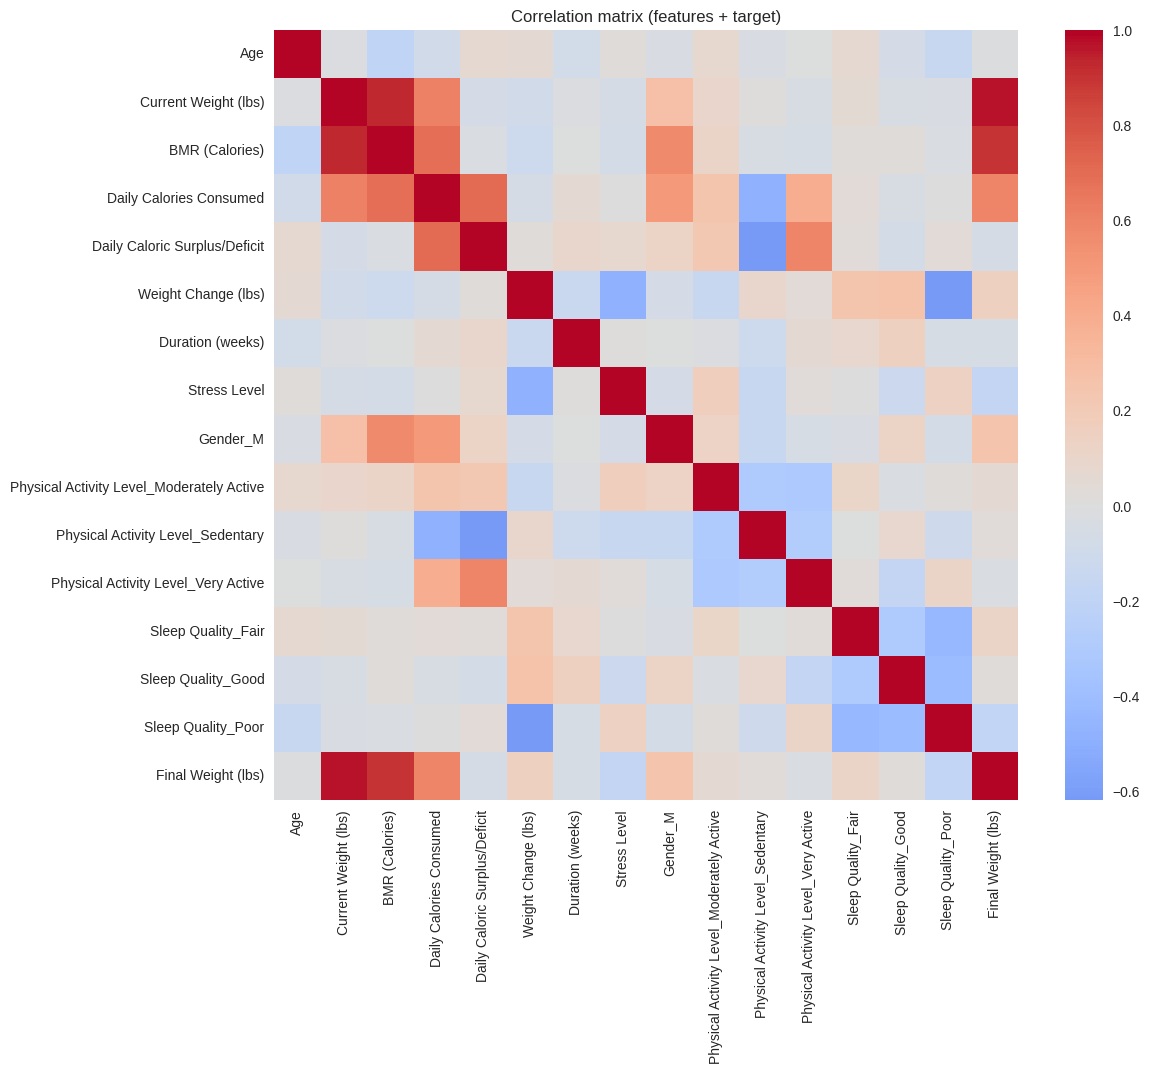

In [ ]:
# Cell 6: Correlation matrix and heatmap (with target)
df_corr = pd.concat([X_prep, y.reset_index(drop=True)], axis=1)
corr = df_corr.corr()
# Show absolute correlation with target sorted
target_corr = corr[target_col].abs().drop(labels=[target_col]).sort_values(ascending=False)
print("Top correlations with target:\n", target_corr.head(15))

# Heatmap (use seaborn)
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title("Correlation matrix (features + target)")
plt.show()


In [ ]:
import json

with open("Diet__Analysis.ipynb") as f:
    nb = json.load(f)

for i, cell in enumerate(nb['cells']):
    print(f"\n\n=== Cell {i} ===")
    if cell['cell_type'] == 'code':
        print("CODE:\n", ''.join(cell['source']))
    else:
        print("MARKDOWN:\n", ''.join(cell['source']))




=== Cell 0 ===
CODE:
 # Cell 0: (Optional) Install required packages (run once)
# If using Colab, run this cell. If running locally, ensure packages are installed.
!pip install -q pandas numpy scikit-learn matplotlib seaborn shap lime joblib scikit-image pdpbox

# Note: pdpbox is optional for PDP plotting; shap and lime are heavy but useful.



=== Cell 1 ===
CODE:
 # Cell 1: Imports & constants
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegres

In [ ]:
# Cell 7: Optionally drop low-correlation features (threshold adjustable)
threshold = 0.05
low_corr_features = target_corr[target_corr < threshold].index.tolist()
print(f"Features with abs(corr) < {threshold} ({len(low_corr_features)}):", low_corr_features)
# If you want to drop them uncomment below:
# X_final = X_prep.drop(columns=low_corr_features)
# For now we'll keep all features
X_final = X_prep.copy()
print("X_final shape:", X_final.shape)


Features with abs(corr) < 0.05 (4): ['Physical Activity Level_Sedentary', 'Physical Activity Level_Very Active', 'Sleep Quality_Good', 'Age']
X_final shape: (100, 15)


In [ ]:
# Cell 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=RANDOM_STATE)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (80, 15) Test shape: (20, 15)


In [ ]:
# Cell 9: Utility functions for metrics and plotting
from math import sqrt

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

def print_metrics(y_true, y_pred, label=''):
    m = regression_metrics(y_true, y_pred)
    print(f"--- {label} metrics ---")
    for k,v in m.items():
        print(f"{k}: {v:.4f}")
    return m

def plot_pred_vs_actual(y_true, y_pred, title='Predicted vs Actual'):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title='Residuals'):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True)
    plt.title(title)
    plt.xlabel('Residual')
    plt.tight_layout()
    plt.show()

def plot_learning_curve(estimator, X, y, title='Learning Curve'):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5,
                                                            train_sizes=np.linspace(0.1,1.0,5),
                                                            scoring='r2', random_state=RANDOM_STATE)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score (R2)')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-val score (R2)')
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Score (R2)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Cell 9: Utility functions for metrics and plotting
from math import sqrt

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

def print_metrics(y_true, y_pred, label=''):
    m = regression_metrics(y_true, y_pred)
    print(f"--- {label} metrics ---")
    for k,v in m.items():
        print(f"{k}: {v:.4f}")
    return m

def plot_pred_vs_actual(y_true, y_pred, title='Predicted vs Actual'):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title='Residuals'):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True)
    plt.title(title)
    plt.xlabel('Residual')
    plt.tight_layout()
    plt.show()

def plot_learning_curve(estimator, X, y, title='Learning Curve'):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5,
                                                            train_sizes=np.linspace(0.1,1.0,5),
                                                            scoring='r2', random_state=RANDOM_STATE)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score (R2)')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-val score (R2)')
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Score (R2)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Cell 10: Models dictionary (instantiate all models)
models = {
    'LinearRegression': LinearRegression(),
    'PolynomialRegression(deg=2)': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('linear', LinearRegression())
    ]),
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Lasso': Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=10000),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'DecisionTree': DecisionTreeRegressor(random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'BayesianRidge': BayesianRidge()
}



========== LinearRegression ==========
--- LinearRegression (Train) metrics ---
MAE: 0.0137
MSE: 0.0004
RMSE: 0.0196
R2: 1.0000
--- LinearRegression (Test) metrics ---
MAE: 0.0174
MSE: 0.0006
RMSE: 0.0247
R2: 1.0000


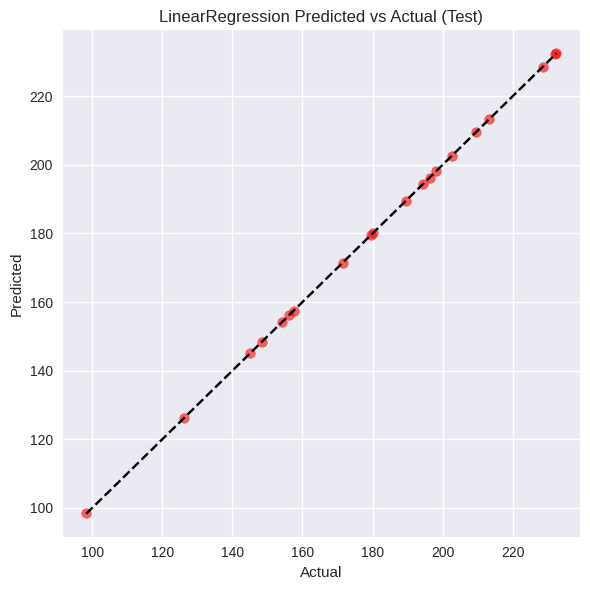

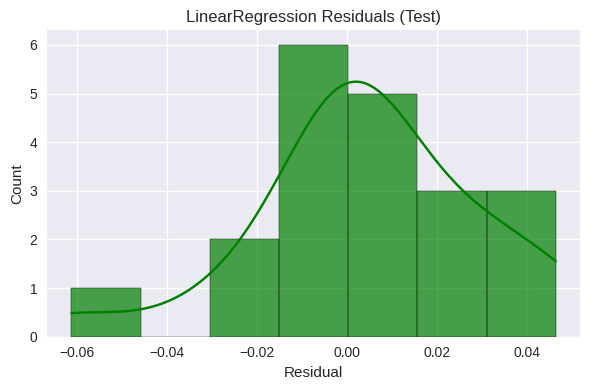

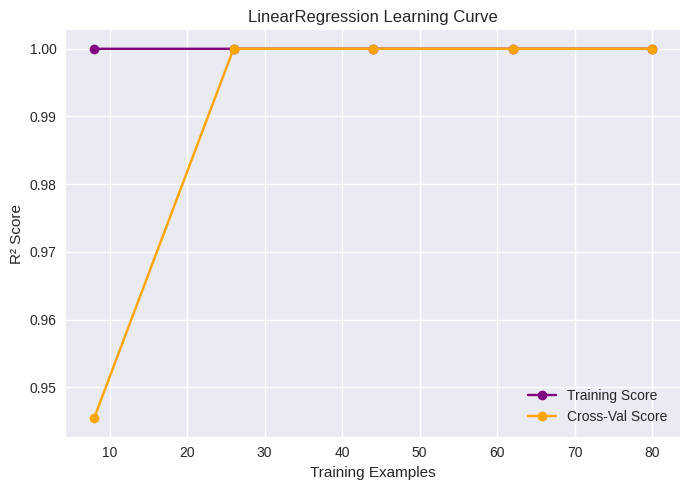


========== PolynomialRegression(deg=2) ==========
--- PolynomialRegression(deg=2) (Train) metrics ---
MAE: 0.0000
MSE: 0.0000
RMSE: 0.0000
R2: 1.0000
--- PolynomialRegression(deg=2) (Test) metrics ---
MAE: 0.9021
MSE: 1.2464
RMSE: 1.1164
R2: 0.9990


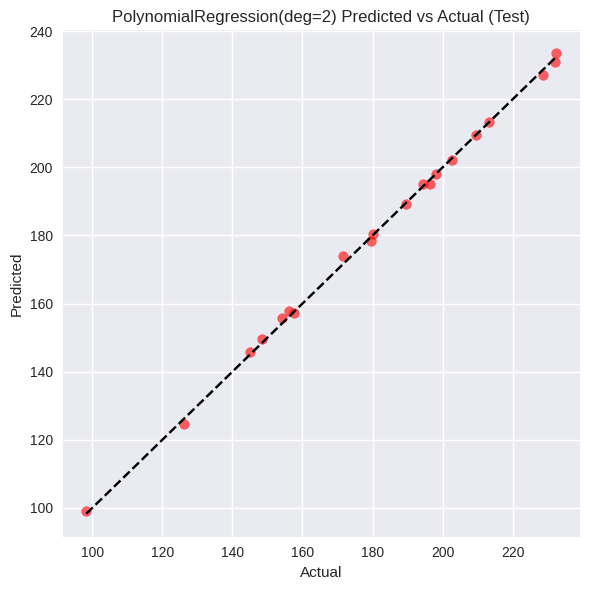

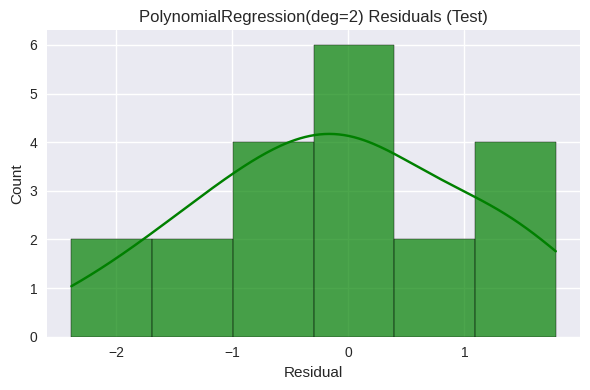

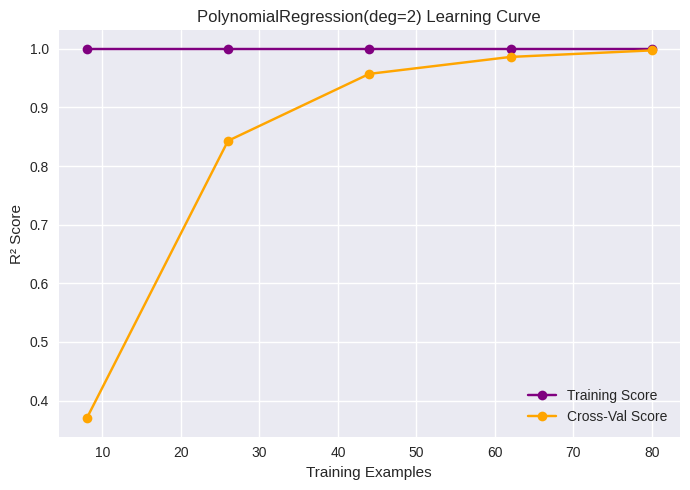


========== Ridge ==========
--- Ridge (Train) metrics ---
MAE: 0.3463
MSE: 0.1748
RMSE: 0.4181
R2: 0.9998
--- Ridge (Test) metrics ---
MAE: 0.4548
MSE: 0.2966
RMSE: 0.5446
R2: 0.9998


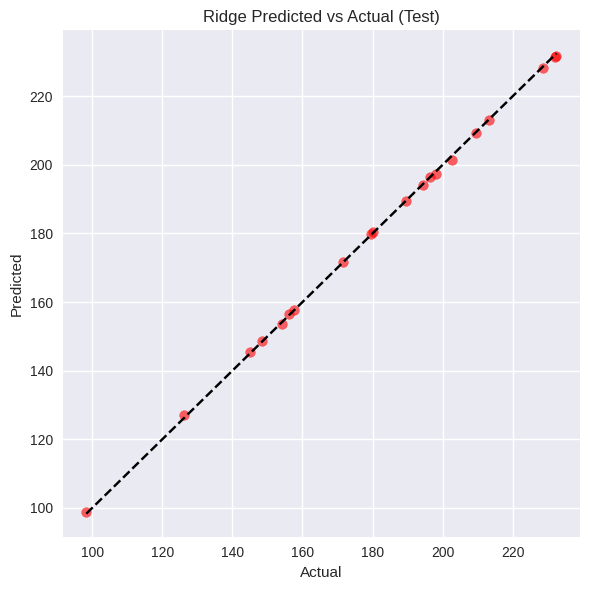

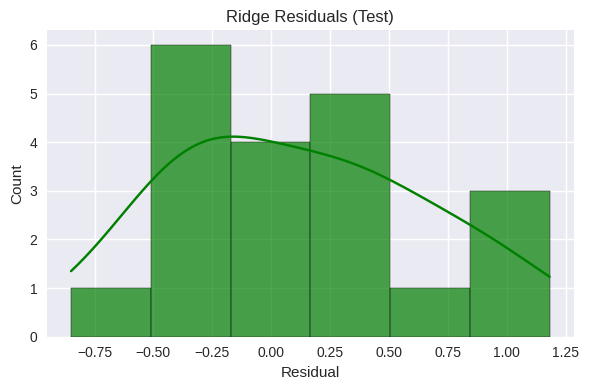

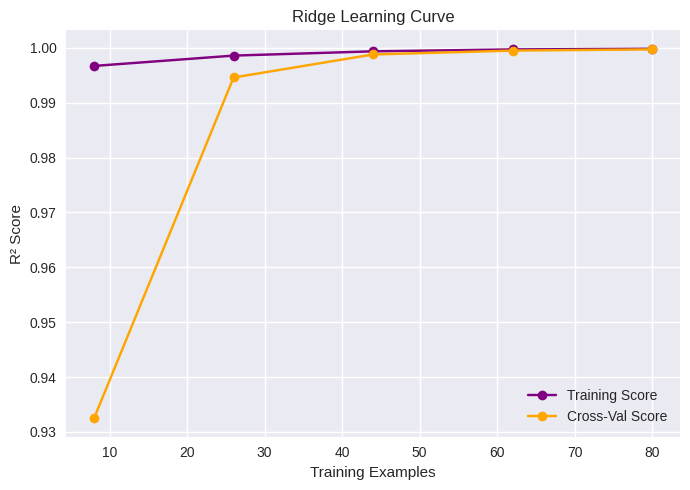


========== Lasso ==========
--- Lasso (Train) metrics ---
MAE: 0.0140
MSE: 0.0004
RMSE: 0.0204
R2: 1.0000
--- Lasso (Test) metrics ---
MAE: 0.0149
MSE: 0.0005
RMSE: 0.0213
R2: 1.0000


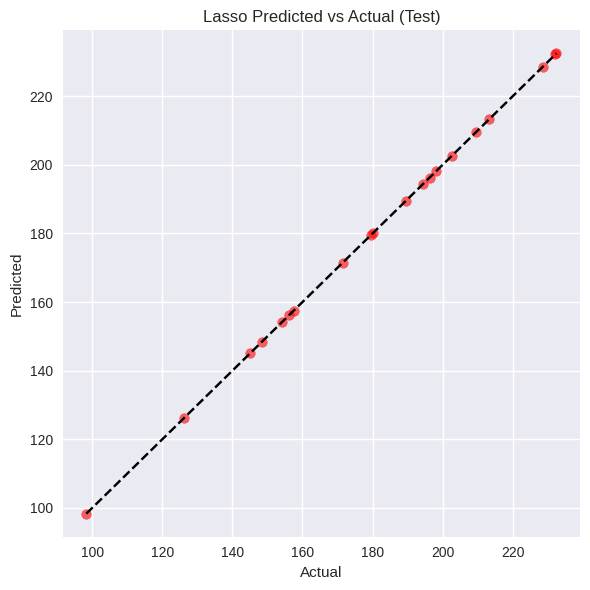

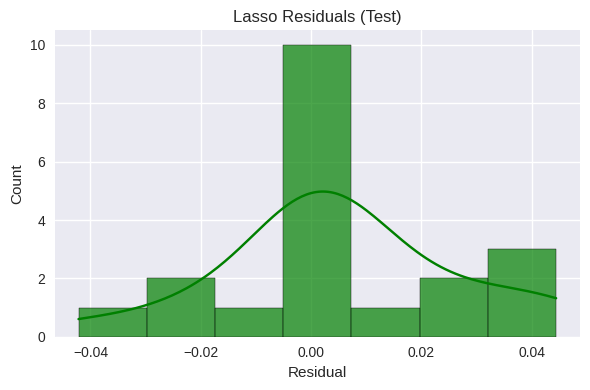

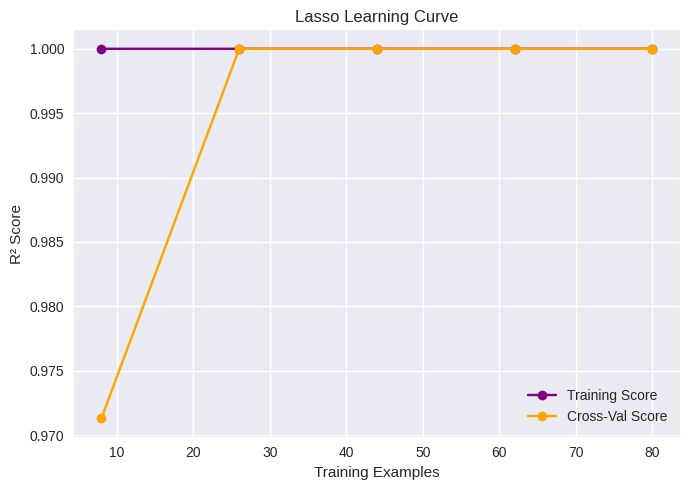


========== ElasticNet ==========
--- ElasticNet (Train) metrics ---
MAE: 0.0206
MSE: 0.0007
RMSE: 0.0273
R2: 1.0000
--- ElasticNet (Test) metrics ---
MAE: 0.0312
MSE: 0.0015
RMSE: 0.0393
R2: 1.0000


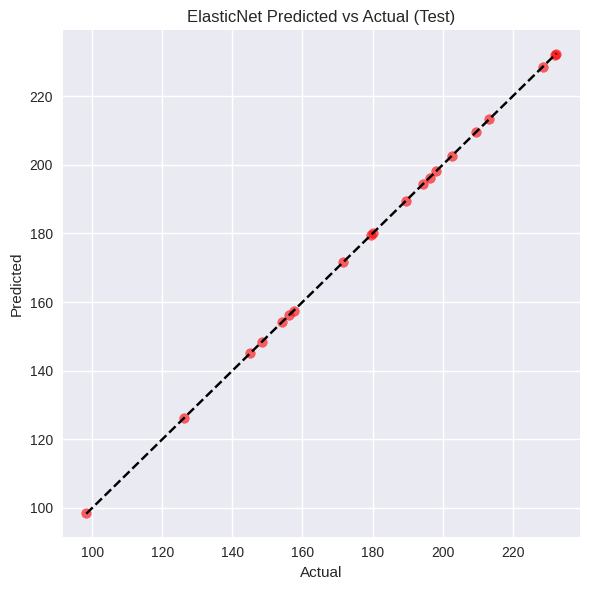

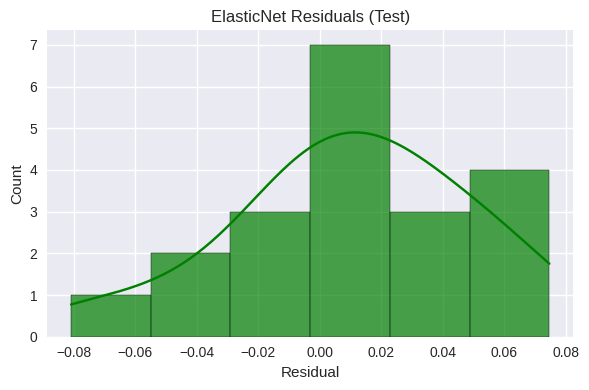

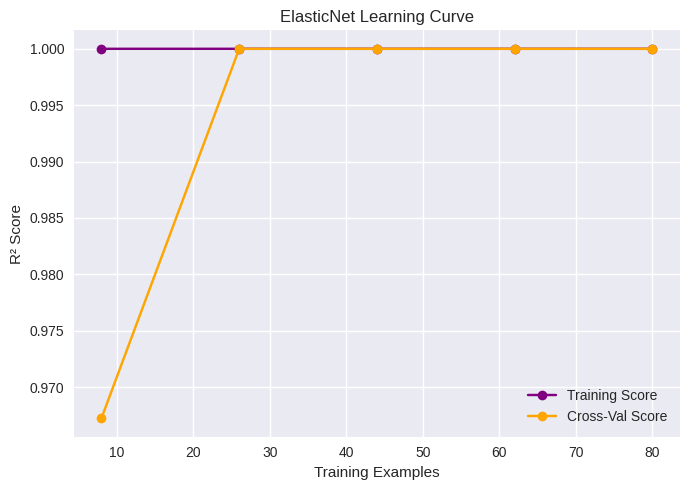


========== SVR ==========
--- SVR (Train) metrics ---
MAE: 18.6584
MSE: 607.7634
RMSE: 24.6529
R2: 0.2433
--- SVR (Test) metrics ---
MAE: 28.2399
MSE: 1166.2926
RMSE: 34.1510
R2: 0.0594


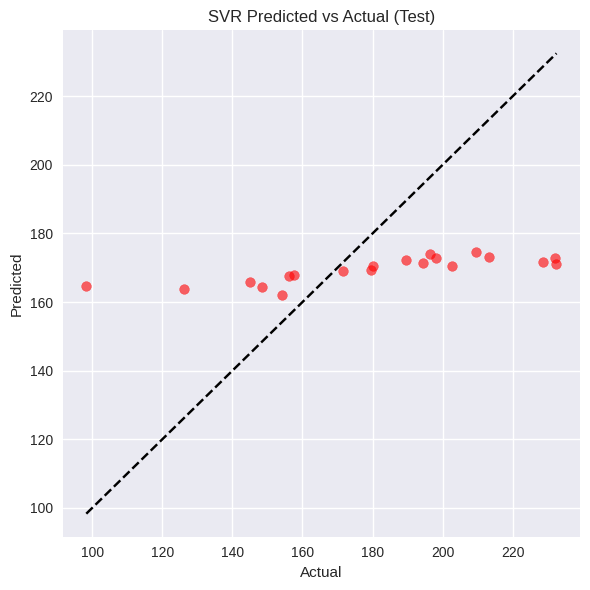

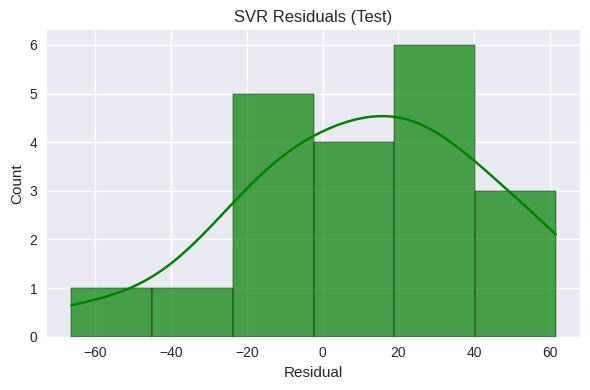

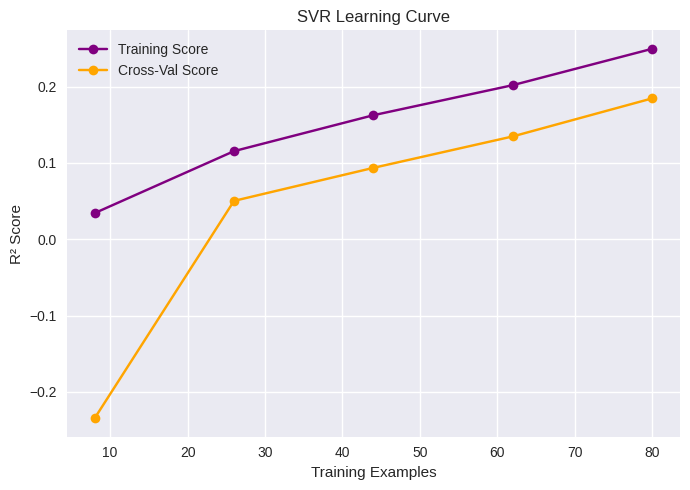


========== DecisionTree ==========
--- DecisionTree (Train) metrics ---
MAE: 0.0000
MSE: 0.0000
RMSE: 0.0000
R2: 1.0000
--- DecisionTree (Test) metrics ---
MAE: 7.3250
MSE: 80.5955
RMSE: 8.9775
R2: 0.9350


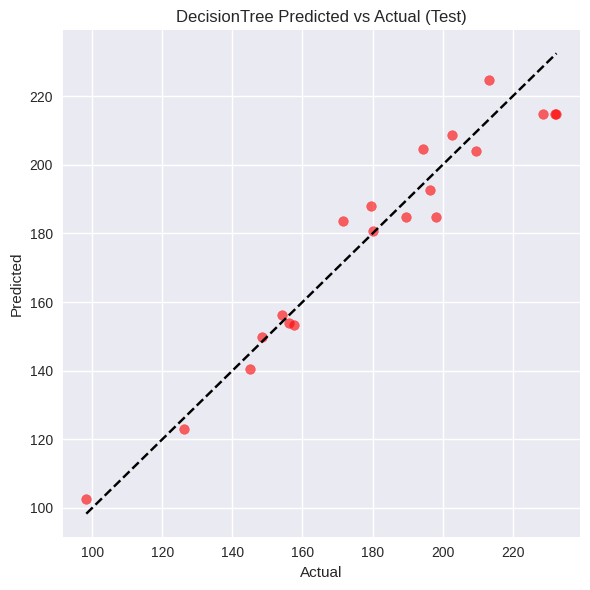

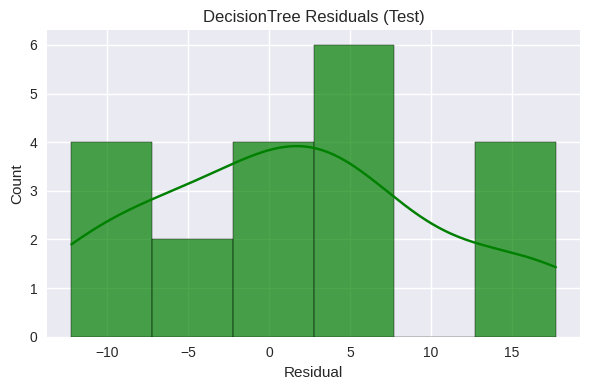

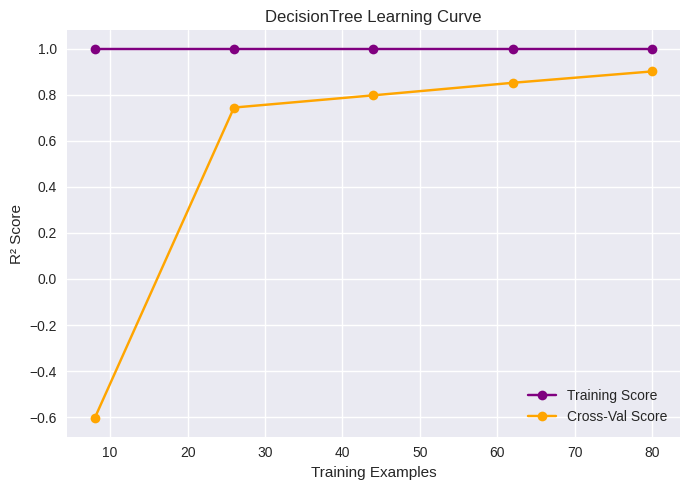


========== RandomForest ==========
--- RandomForest (Train) metrics ---
MAE: 1.9236
MSE: 7.4194
RMSE: 2.7239
R2: 0.9908
--- RandomForest (Test) metrics ---
MAE: 5.0849
MSE: 41.5744
RMSE: 6.4478
R2: 0.9665


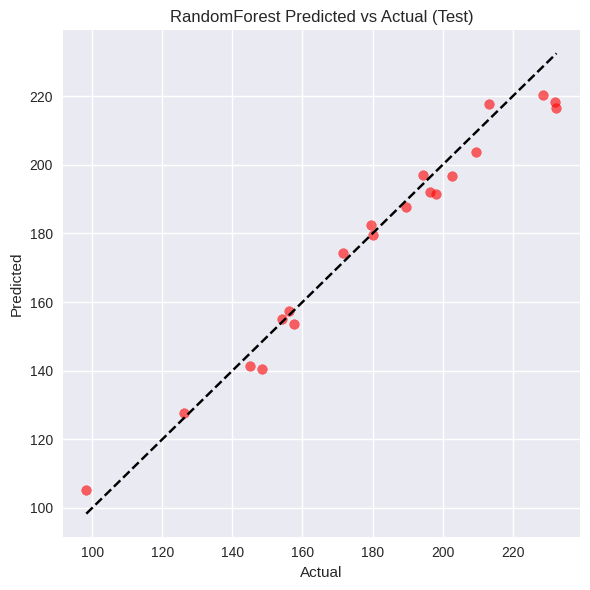

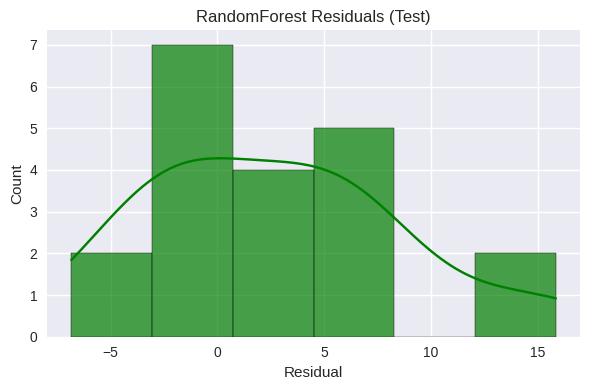

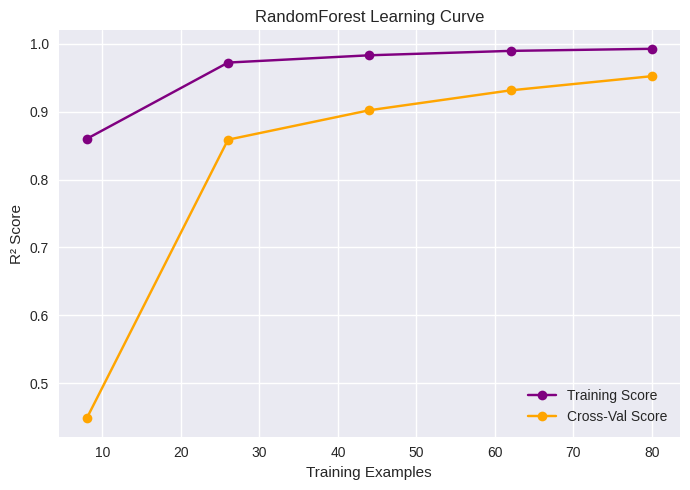


========== KNN ==========
--- KNN (Train) metrics ---
MAE: 9.5693
MSE: 152.2709
RMSE: 12.3398
R2: 0.8104
--- KNN (Test) metrics ---
MAE: 13.9900
MSE: 282.2167
RMSE: 16.7993
R2: 0.7724


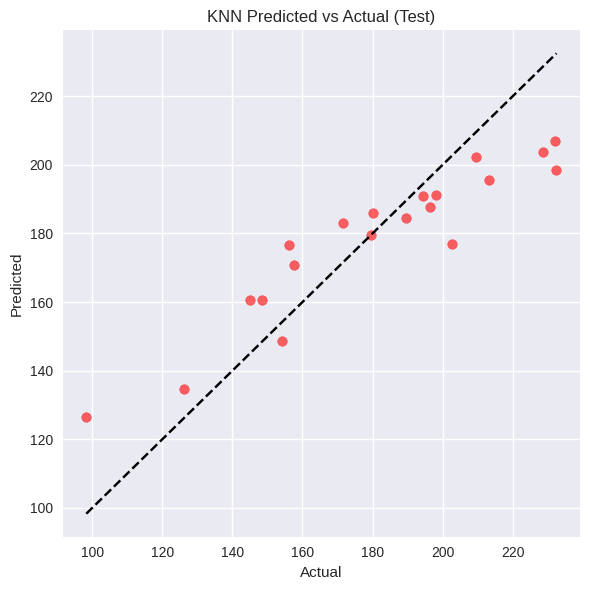

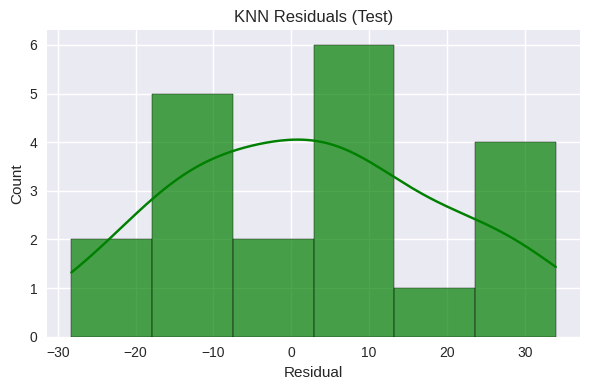

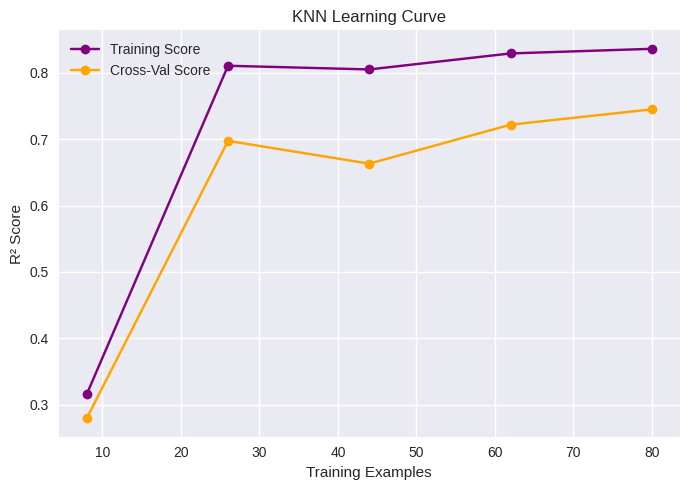


========== BayesianRidge ==========
--- BayesianRidge (Train) metrics ---
MAE: 0.0140
MSE: 0.0004
RMSE: 0.0198
R2: 1.0000
--- BayesianRidge (Test) metrics ---
MAE: 0.0176
MSE: 0.0006
RMSE: 0.0247
R2: 1.0000


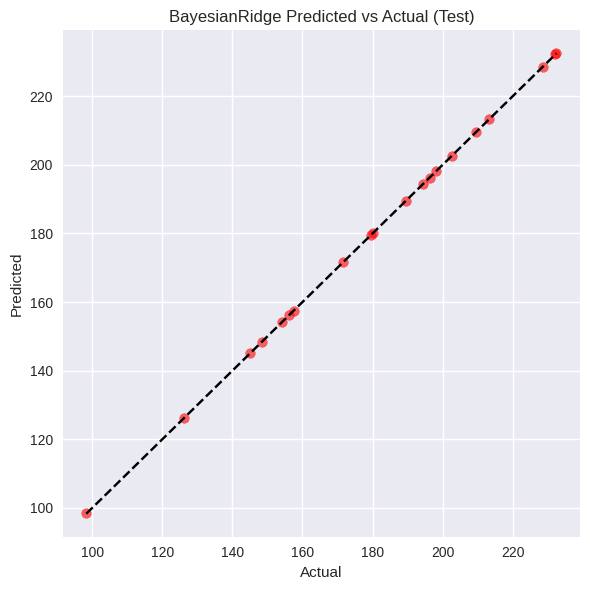

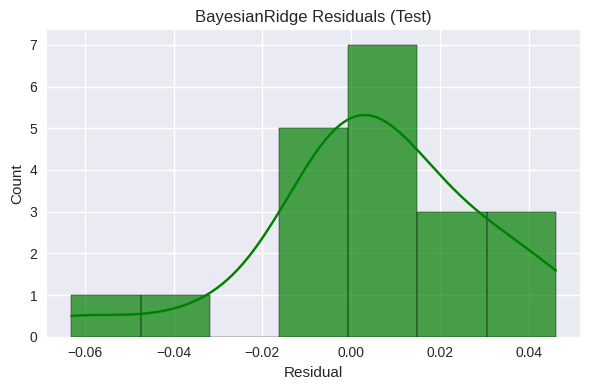

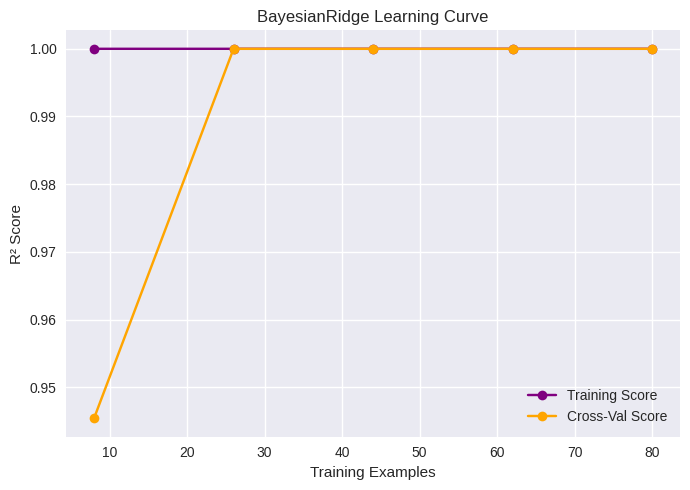

,Model,Test_RMSE,Test_R2
3,Lasso,0.021346,1.000000
0,LinearRegression,0.024666,1.000000
9,BayesianRidge,0.024679,1.000000
4,ElasticNet,0.039340,0.999999
2,Ridge,0.544572,0.999761
1,PolynomialRegression(deg=2),1.116405,0.998995
7,RandomForest,6.447822,0.966470
6,DecisionTree,8.977500,0.934999
8,KNN,16.799307,0.772390
5,SVR,34.151026,0.059375


In [ ]:
# Cell 11: Train & evaluate each model and store results
results = {}
for name, model in models.items():
    print("\n==========", name, "==========")
    # Some models (SVR, KNN) need scaled data; X_final already scaled numerics but if you used MinMax or something else adjust.
    # For Polynomial pipeline we already included polynomial feature step.
    model.fit(X_train, y_train)
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # Metrics
    train_metrics = print_metrics(y_train, y_train_pred, label=f'{name} (Train)')
    test_metrics = print_metrics(y_test, y_test_pred, label=f'{name} (Test)')
    # Plots
    plot_pred_vs_actual(y_test, y_test_pred, title=f'{name} Predicted vs Actual (Test)')
    plot_residuals(y_test, y_test_pred, title=f'{name} Residuals (Test)')
    plot_learning_curve(model, X_final, y, title=f'{name} Learning Curve')
    # Save results
    results[name] = {
        'model': model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics
    }

# Show comparison table of key metrics (Test RMSE and R2)
comp = []
for name, r in results.items():
    comp.append([name, r['test_metrics']['RMSE'], r['test_metrics']['R2']])
comp_df = pd.DataFrame(comp, columns=['Model','Test_RMSE','Test_R2']).sort_values(by='Test_RMSE')
display(comp_df)


In [ ]:
# === UPDATED PLOT FUNCTIONS WITH COLOR CHANGES ===

def plot_pred_vs_actual(y_true, y_pred, title='Predicted vs Actual'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, color='red', alpha=0.6)     # 🔴 color changed
    plt.plot([min(y_true), max(y_true)],
             [min(y_true), max(y_true)],
             color='black', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_residuals(y_true, y_pred, title='Residuals'):
    import matplotlib.pyplot as plt
    import seaborn as sns
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True, color='green', alpha=0.7)   # 🟢 color changed
    plt.title(title)
    plt.xlabel('Residual')
    plt.tight_layout()
    plt.show()


def plot_learning_curve(estimator, X, y, title='Learning Curve'):
    import matplotlib.pyplot as plt
    from sklearn.model_selection import learning_curve
    import numpy as np

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, 'o-', color='purple', label='Training Score')  # 🟣 color changed
    plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Cross-Val Score')  # 🟧 color changed
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("R² Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Cell 12: Hyperparameter tuning examples (Ridge, Lasso, ElasticNet, SVR, RandomForest)
# This is optional and may take time. Example: GridSearch for Ridge alpha and RF n_estimators
tune_results = {}

# Ridge GridSearch
from sklearn.model_selection import GridSearchCV
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10, 100]}
gs_ridge = GridSearchCV(Ridge(random_state=RANDOM_STATE), ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_ridge.fit(X_train, y_train)
print("Ridge best:", gs_ridge.best_params_, "Best MSE:", -gs_ridge.best_score_)
tune_results['Ridge'] = gs_ridge.best_estimator_

# Lasso GridSearch
lasso_params = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1]}
gs_lasso = GridSearchCV(Lasso(random_state=RANDOM_STATE, max_iter=10000), lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_lasso.fit(X_train, y_train)
print("Lasso best:", gs_lasso.best_params_)
tune_results['Lasso'] = gs_lasso.best_estimator_

# ElasticNet GridSearch
en_params = {'alpha': [1e-4,1e-3,1e-2,1e-1,1], 'l1_ratio': [0.2,0.5,0.8]}
gs_en = GridSearchCV(ElasticNet(random_state=RANDOM_STATE, max_iter=10000), en_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_en.fit(X_train, y_train)
print("ElasticNet best:", gs_en.best_params_)
tune_results['ElasticNet'] = gs_en.best_estimator_

# RandomForest small grid
rf_params = {'n_estimators': [100,200], 'max_depth': [None, 5, 10]}
gs_rf = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gs_rf.fit(X_train, y_train)
print("RandomForest best:", gs_rf.best_params_)
tune_results['RandomForest'] = gs_rf.best_estimator_

# SVR tuning (scale-sensitive; already scaled numerics but ensure scaling)
svr_params = {'C': [0.1,1,10], 'epsilon':[0.01,0.1,0.5]}
gs_svr = GridSearchCV(SVR(kernel='rbf'), svr_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gs_svr.fit(X_train, y_train)
print("SVR best:", gs_svr.best_params_)
tune_results['SVR'] = gs_svr.best_estimator_

# Evaluate tuned models on test set
for name, model in tune_results.items():
    y_pred = model.predict(X_test)
    print("\nTuned", name)
    print_metrics(y_test, y_pred, label=f'{name} (Test tuned)')


Ridge best: {'alpha': 0.01} Best MSE: 0.0007568029948872366
Lasso best: {'alpha': 0.001}
ElasticNet best: {'alpha': 0.0001, 'l1_ratio': 0.8}
RandomForest best: {'max_depth': None, 'n_estimators': 200}
SVR best: {'C': 10, 'epsilon': 0.01}

Tuned Ridge
--- Ridge (Test tuned) metrics ---
MAE: 0.0213
MSE: 0.0008
RMSE: 0.0284
R2: 1.0000

Tuned Lasso
--- Lasso (Test tuned) metrics ---
MAE: 0.0149
MSE: 0.0005
RMSE: 0.0213
R2: 1.0000

Tuned ElasticNet
--- ElasticNet (Test tuned) metrics ---
MAE: 0.0174
MSE: 0.0006
RMSE: 0.0249
R2: 1.0000

Tuned RandomForest
--- RandomForest (Test tuned) metrics ---
MAE: 5.0849
MSE: 41.5744
RMSE: 6.4478
R2: 0.9665

Tuned SVR
--- SVR (Test tuned) metrics ---
MAE: 13.3182
MSE: 395.8812
RMSE: 19.8968
R2: 0.6807



Top features for RandomForest


,0
Current Weight (lbs),0.889577
BMR (Calories),0.043547
Weight Change (lbs),0.034111
Duration (weeks),0.006788
Stress Level,0.005764
Daily Caloric Surplus/Deficit,0.004285
Age,0.004016
Sleep Quality_Poor,0.003852
Daily Calories Consumed,0.003065
Physical Activity Level_Moderately Active,0.001500


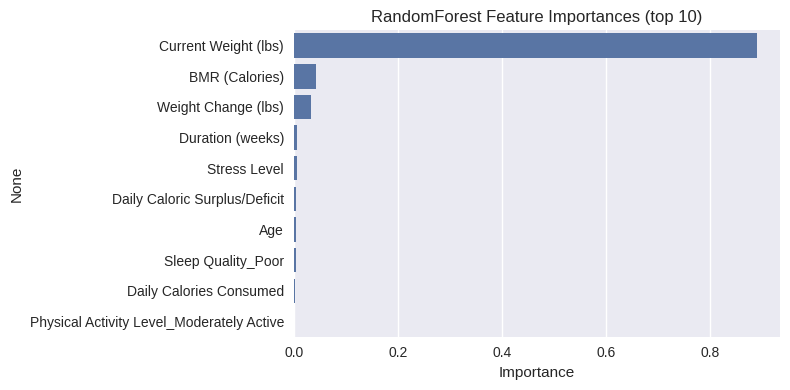


Top features for DecisionTree


,0
Current Weight (lbs),0.939079
Weight Change (lbs),0.047479
BMR (Calories),0.002282
Daily Caloric Surplus/Deficit,0.002190
Sleep Quality_Fair,0.002050
Age,0.001934
Duration (weeks),0.001209
Physical Activity Level_Sedentary,0.001181
Stress Level,0.001163
Physical Activity Level_Moderately Active,0.000568


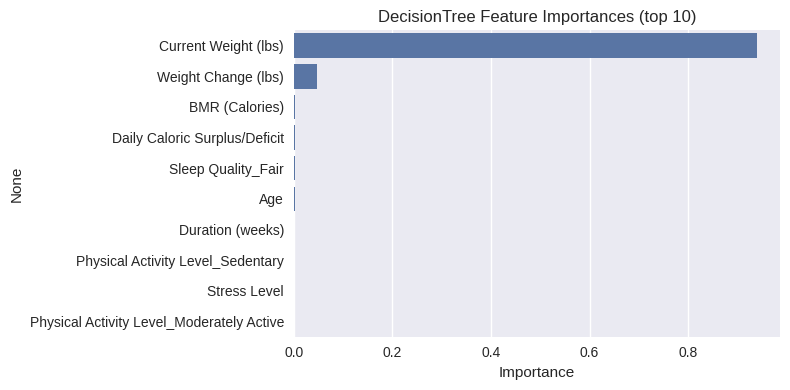

In [ ]:
# Cell 13: Feature importance for tree-based models (RandomForest & DecisionTree)
for name in ['RandomForest', 'DecisionTree']:
    if name in results:
        model = results[name]['model']
        if hasattr(model, 'feature_importances_'):
            fi = pd.Series(model.feature_importances_, index=X_final.columns).sort_values(ascending=False)
            print("\nTop features for", name)
            display(fi.head(15))
            plt.figure(figsize=(8,4))
            sns.barplot(x=fi.head(10), y=fi.head(10).index)
            plt.title(f"{name} Feature Importances (top 10)")
            plt.xlabel("Importance")
            plt.tight_layout()
            plt.show()
        else:
            print(name, "doesn't have feature_importances_ attribute.")


SHAP summary plot (global):


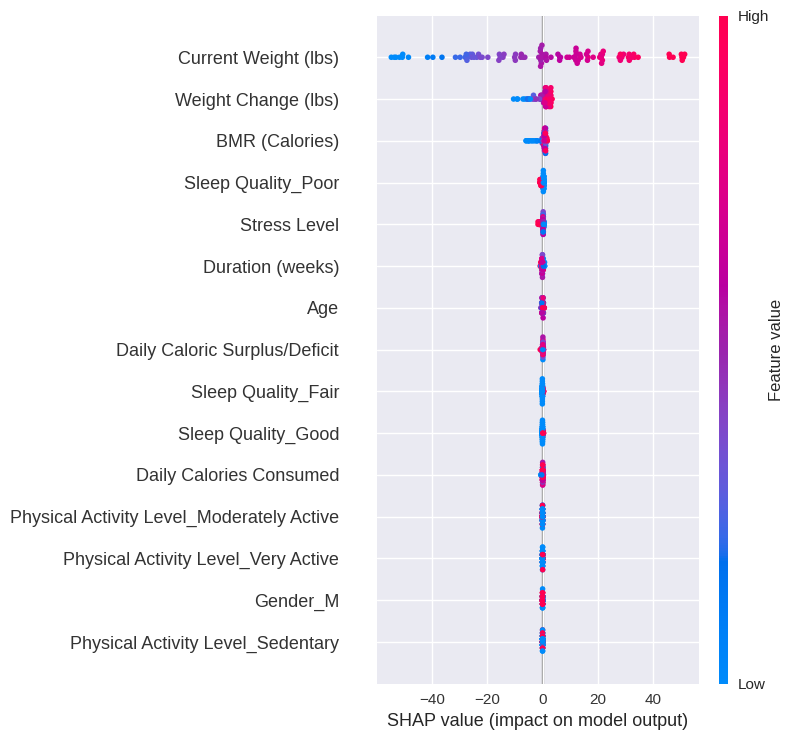

Top feature for dependence plot: Current Weight (lbs)


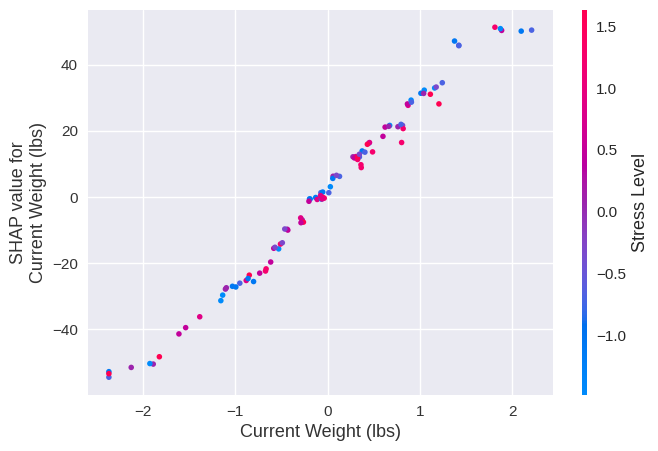

In [ ]:
# Cell 14: SHAP explanations (global + dependence) for RandomForest (or tuned RF)
# WARNING: SHAP can be slow for many features and many rows. You may sample rows for speed.
rf_model = tune_results.get('RandomForest', results['RandomForest']['model'])
# Use only a sample for SHAP to avoid heavy runtime if dataset big
shap_sample = X_final.sample(n=min(200, len(X_final)), random_state=RANDOM_STATE)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(shap_sample)

# Summary plot
print("SHAP summary plot (global):")
shap.summary_plot(shap_values, shap_sample)

# Dependence plot for top feature
top_feature = list(pd.Series(rf_model.feature_importances_, index=X_final.columns).sort_values(ascending=False).index[:1])[0]
print("Top feature for dependence plot:", top_feature)
shap.dependence_plot(top_feature, shap_values, shap_sample)


LIME explanation (as list):


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[('Current Weight (lbs) <= -0.63', -46.61767705257306),
 ('0.40 < Weight Change (lbs) <= 0.63', 2.6177795087011133),
 ('Age <= -0.84', -0.7176171094402048),
 ('Sleep Quality_Poor <= 0.00', 0.6206871579093715),
 ('0.07 < Stress Level <= 0.85', 0.4916865218172592),
 ('Physical Activity Level_Moderately Active <= 0.00', 0.43983512774721145),
 ('Daily Calories Consumed <= -0.59', -0.34561702557572604),
 ('0.00 < Gender_M <= 1.00', 0.32897399775268793)]

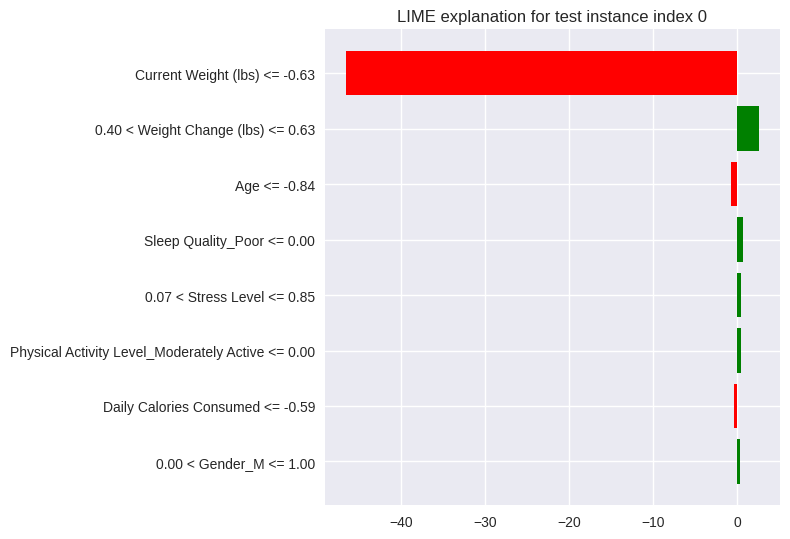

In [ ]:
# Cell 15: LIME (local explanation) for regression
# We'll use the training set to build the explainer. LIME expects a numpy array and feature names.
explainer_lime = LimeTabularExplainer(training_data=np.array(X_train),
                                      feature_names=X_train.columns.tolist(),
                                      mode='regression')
# Explain a test instance
idx = 0  # change to other index to explain different instances
x_to_explain = X_test.iloc[idx].values
exp = explainer_lime.explain_instance(x_to_explain, predict_fn=rf_model.predict, num_features=8)
print("LIME explanation (as list):")
display(exp.as_list())
fig = exp.as_pyplot_figure()
plt.title(f"LIME explanation for test instance index {idx}")
plt.tight_layout()
plt.show()


PDP & ICE top features: ['Current Weight (lbs)', 'BMR (Calories)']


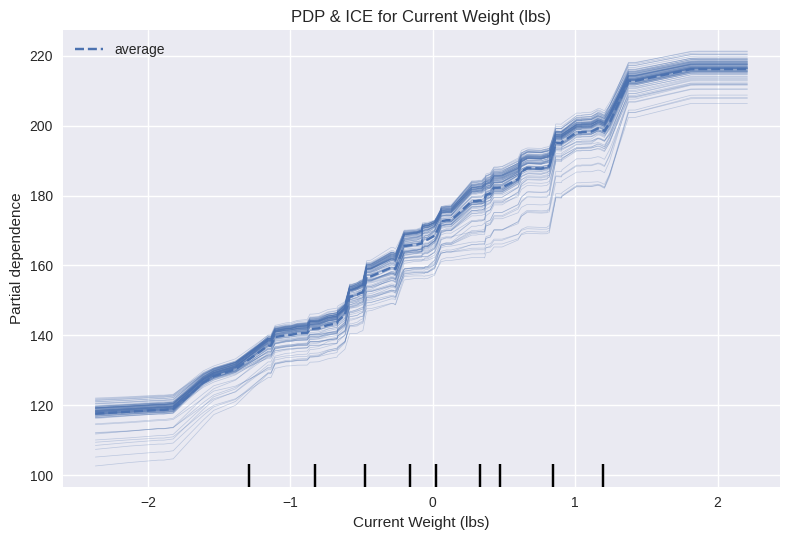

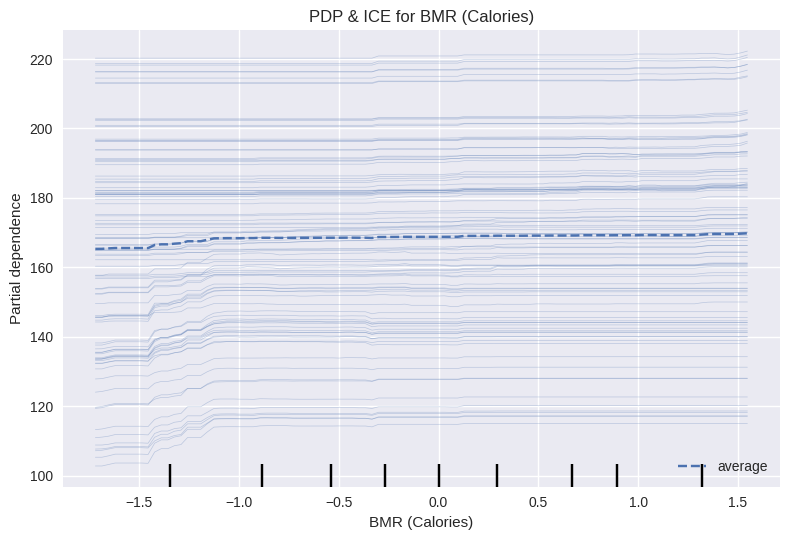

In [ ]:
# Cell 16: PDP & ICE for top 2 features (use PartialDependenceDisplay)
top_feats = pd.Series(rf_model.feature_importances_, index=X_final.columns).sort_values(ascending=False).index[:2].tolist()
print("PDP & ICE top features:", top_feats)
for feat in top_feats:
    try:
        PartialDependenceDisplay.from_estimator(rf_model, X_final, [feat], kind='both')
        plt.title(f"PDP & ICE for {feat}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("PDP failed for", feat, e)


In [ ]:
# Cell 17: Save the best-performing model (by test RMSE) and processed dataset
# Determine best model by test RMSE from results and tuned results
all_models_for_compare = {}
for name, info in results.items():
    all_models_for_compare[name] = info['test_metrics']['RMSE']
for name, m in tune_results.items():
    # compute test RMSE for tuned
    rmse = sqrt(mean_squared_error(y_test, m.predict(X_test)))
    all_models_for_compare[f"{name}_tuned"] = rmse

best_model_name = min(all_models_for_compare, key=all_models_for_compare.get)
print("Best model by Test RMSE:", best_model_name, "RMSE:", all_models_for_compare[best_model_name])

# Save best model object
if best_model_name.endswith('_tuned'):
    model_to_save = tune_results[best_model_name.replace('_tuned','')]
else:
    model_to_save = results[best_model_name]['model']

joblib.dump(model_to_save, "best_model.joblib")
print("Saved best model to best_model.joblib")

# Save processed dataset
X_final_copy = X_final.copy()
X_final_copy[target_col] = y.values
X_final_copy.to_csv("processed_dataset.csv", index=False)
print("Saved processed dataset to processed_dataset.csv")


Best model by Test RMSE: Lasso RMSE: 0.02134613120022663
Saved best model to best_model.joblib
Saved processed dataset to processed_dataset.csv


In [ ]:
# Cell 18: Summary of outputs & tips
print("Saved files in current directory:", os.listdir('.'))
print("\nSummary:")
pprint(comp_df.sort_values('Test_RMSE').head(10))
print("\nTips:")
print("- If SHAP is slow, reduce sample size for shap.sample or use KernelExplainer on fewer features.")
print("- LIME explanations are local; check multiple instances.")
print("- For deeper hyperparameter tuning, extend GridSearchCV grids or use RandomizedSearchCV.")
print("- For neural-network training curves use Keras and collect epoch metrics.")


Saved files in current directory: ['.config', 'best_model.joblib', 'processed_dataset.csv', 'weight_change_dataset.csv', 'sample_data']

Summary:
                         Model  Test_RMSE   Test_R2
3                        Lasso   0.021346  1.000000
0             LinearRegression   0.024666  1.000000
9                BayesianRidge   0.024679  1.000000
4                   ElasticNet   0.039340  0.999999
2                        Ridge   0.544572  0.999761
1  PolynomialRegression(deg=2)   1.116405  0.998995
7                 RandomForest   6.447822  0.966470
6                 DecisionTree   8.977500  0.934999
8                          KNN  16.799307  0.772390
5                          SVR  34.151026  0.059375

Tips:
- If SHAP is slow, reduce sample size for shap.sample or use KernelExplainer on fewer features.
- LIME explanations are local; check multiple instances.
- For deeper hyperparameter tuning, extend GridSearchCV grids or use RandomizedSearchCV.
- For neural-network training cur